In [1]:
import pandas as pd
import numpy as np
import gc # 垃圾处理机制 garbage collection 
import pickle #save data as .pkl
from tqdm import tqdm
from itertools import product 

from sklearn.externals import joblib # save models
from sklearn import preprocessing
from xgboost import XGBRegressor # 当 variables 少但是数据大的时候
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
def plot_features(booster,figsize):
    fig,ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster,ax=ax)

def downcast_dtypes(df): 
    float_cols = [c for c in df if df[c].dtype == 'float64' ]
    int_cols = [c for c in df if df[c].dtype in ['int32','int64'] ]
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [3]:
import os
data_dir = '/kaggle/input/competitive-data-science-predict-future-sales'
os.listdir(data_dir)

['test.csv',
 'item_categories.csv',
 'sales_train.csv',
 'sample_submission.csv',
 'items.csv',
 'shops.csv']

In [4]:
train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


##Goal: predict item_cnt_month

In [6]:
item_catg = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
item_catg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [7]:
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [8]:
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales//shops.csv')
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


### EDA 
To delete duplicate numbers.

In [9]:
#Here I comment out this block to save running time.
"""import pandas_profiling as ppf
train_report = ppf.ProfileReport(train) #EDA 
train_report.to_file(output_file="eda-report/train.html")
test_report = ppf.ProfileReport(test) #EDA 
test_report.to_file(output_file="eda-report/test.html")
item_report = ppf.ProfileReport(items) #EDA 
item_report.to_file(output_file="eda-report/item.html")
shops_report = ppf.ProfileReport(shops) #EDA 
shops_report.to_file(output_file="eda-report/shops.html")
item_catg_report = ppf.ProfileReport(item_catg) #EDA 
item_catg_report.to_file(output_file="eda-report/item_catg.html")"""

'import pandas_profiling as ppf\ntrain_report = ppf.ProfileReport(train) #EDA \ntrain_report.to_file(output_file="eda-report/train.html")\ntest_report = ppf.ProfileReport(test) #EDA \ntest_report.to_file(output_file="eda-report/test.html")\nitem_report = ppf.ProfileReport(items) #EDA \nitem_report.to_file(output_file="eda-report/item.html")\nshops_report = ppf.ProfileReport(shops) #EDA \nshops_report.to_file(output_file="eda-report/shops.html")\nitem_catg_report = ppf.ProfileReport(item_catg) #EDA \nitem_catg_report.to_file(output_file="eda-report/item_catg.html")'

In [10]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


## Preprocessing with the `train` and `test` set

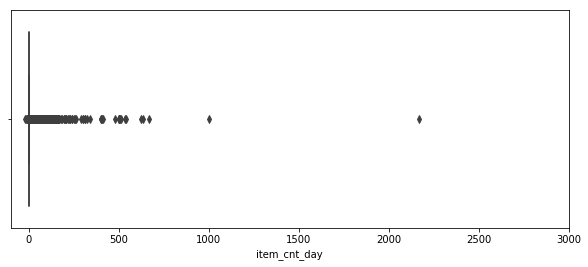

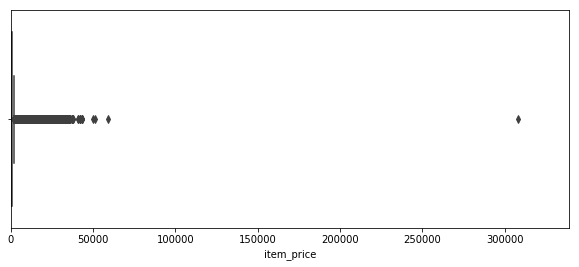

CPU times: user 2.82 s, sys: 1.03 s, total: 3.84 s
Wall time: 2.81 s


In [11]:
%%time
plt.figure(figsize = (10,4))
plt.xlim(-100,3000)
sns.boxplot(x=train.item_cnt_day)
plt.show()
plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(),train.item_price.max()*1.1) # multiply
sns.boxplot(x=train.item_price)
plt.show()


In [12]:
# delete outliers
train = train[train.item_cnt_day<1001]
train = train[train.item_cnt_day>0]
train = train[train.item_price<250000]
train = train[train.item_price>1]
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0


Fill in the negative prices with median.

In [13]:
median = train[(train.item_price>0)].item_price.median()
train.loc[train.item_price<0,'item_price'] = median

# remove duplicate rows

train.drop_duplicates(subset =['date','date_block_num','item_id','item_price','item_cnt_day'],keep='first',inplace=True)

In [14]:
# keep the consistancy of the training set and test set
# shop_name 一样
train.loc[train.shop_id==0,'shop_id']=57
test.loc[test.shop_id ==0,'shop_id']=57
train.loc[train.shop_id==1,'shop_id']=58
test.loc[test.shop_id ==1,'shop_id']=58
train.loc[train.shop_id==10,'shop_id']=11
test.loc[test.shop_id ==10,'shop_id']=11

In [15]:
train = train.merge(test[['shop_id']].drop_duplicates(),how = 'inner')

## Preprocessing with the `shops` dataset

In [16]:
# get the city
#shops.loc[shops.shop_name=='Сергиев Посад ТЦ "7Я"','shop_name'] = 'Сергиев Посад ТЦ "7Я"' 
shops['city']=shops.shop_name.str.split(' ').map(lambda x:x[0])
shops.loc[shops.city=='!Якутск','city'] = 'Якутск'
shops['shop_city'] = LabelEncoder().fit_transform(shops.city)

# get shop's name
shops['names'] = shops['shop_name'].apply(lambda x:x.lower()).str.replace('[^\w\s]','').str.replace('\d+','').str.strip()
shops['shop_new_name']=LabelEncoder().fit_transform(shops.names)

In [17]:
# get the type of shops
shops['type']= shops.names.apply(lambda x: 'МТРЦ' if 'МТРЦ' in x 
                                 else 'ТРЦ' if 'ТРЦ' in x 
                                 else 'ТЦ' if 'ТЦ' in x
                                 else 'ТРК' if 'ТРК' in x
                                 else 'ТК' if 'ТК' in x
                                 else 'No_data')
shops['shop_type'] = shops.type.map({'No_data':0,'МТРЦ' :1,'ТРЦ':2,
                                    'ТЦ':3, 'ТРК':4,'ТК' :5})
shops = shops[['shop_id','shop_city','shop_new_name','shop_type']]

##  Preprocessing with `item_category_id` set

In [18]:
item_catg.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [19]:
# split item's name
item_catg['split'] = item_catg.item_category_name.str.split('-')
item_catg['type'] = item_catg['split'].map(lambda x:x[0].strip())
item_catg['item_type'] = LabelEncoder().fit_transform(item_catg['type'])

# get rid of space
item_catg['subtype']=item_catg.split.map(lambda x:x[1].strip() if len(x)>1 else x[0].strip())
item_catg['item_subtype'] = LabelEncoder().fit_transform(item_catg.subtype)

item_catg = item_catg[['item_category_id','item_type','item_subtype']]

In [20]:
item_catg

,item_category_id,item_type,item_subtype
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13
5,5,1,14
6,6,1,16
7,7,1,17
8,8,2,26
9,9,3,33


## Preprocessing with the `items` dataset 

In [21]:
# isolate the itrm name
items['name1'],items['name2']=items.item_name.str.split('[',1).str
items['name1'],items['name3']=items.item_name.str.split('(',1).str
items.name2=items.name2.str.replace('[A-Za-z0-9A-Яа-я+]',' ').str.lower()
items.name3=items.name3.str.replace('[A-Za-z0-9A-Яа-я+]',' ').str.lower()

items= items.fillna('0')
items['name_1'] =LabelEncoder().fit_transform(items.name1)
items['name_2'] =LabelEncoder().fit_transform(items.name2) 
items['name_3'] =LabelEncoder().fit_transform(items.name3)
items = items[['item_id','item_category_id','name_1','name_2','name_3']]

# feature engineering: 

In [22]:
matrix = []
cols = [ 'date_block_num', 'shop_id', 'item_id'] # variables from training set
for i in train.date_block_num.unique():
    sales = train[train.date_block_num == i]
    matrix.append(np.array(list(product([i],sales.shop_id.unique(),sales.item_id.unique())),dtype = 'int16')) # product is a iteration tool

matrix = pd.DataFrame(np.vstack(matrix),columns = cols)
matrix.date_block_num = matrix.date_block_num.astype(np.int8)
matrix.shop_id = matrix.shop_id.astype(np.int8)
matrix.item_id = matrix.item_id.astype(np.int16)
matrix.sort_values(cols,inplace = True)

In [23]:
# get the sales amount in each month for each item
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

In [24]:
matrix = pd.merge(matrix,group,on=cols,how='left')
matrix['item_cnt_month'] = matrix.item_cnt_month.fillna(0).clip(0,20).astype(np.float16)

Get the `test` and `train` set combined.

In [25]:
test['date_block_num'] = 34 #34 就是第35个月,因为要对第35个月的销售额进行预测
matrix = pd.concat([matrix,test],ignore_index=True,sort=False,keys=cols)
matrix.fillna(0,inplace=True)

#delete test 
gc.collect() # 垃圾回收

68

In [26]:
matrix = pd.merge(matrix,shops,on=['shop_id'],how = 'left')
matrix = pd.merge(matrix,items,on=['item_id'],how='left')
matrix = pd.merge(matrix,item_catg,on = ['item_category_id'],how='left')
del shops,items,item_catg
gc.collect()

84

## feature engineering, now need to make some new columns


In [27]:
# 把所有分散的 dataset 做成一个文件
# 是否数据预处理可以结束，直接 train models and predict

In [28]:
def lag_feature(df,lags,col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id',col+'_lag_'+ str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df,shifted,on=['date_block_num','shop_id','item_id'],how='left')
    return df
def add(list_names,list_num):
    global matrix
    str1 = list_names[0]
    for i in range(1,len(list_names)):
        str1 = str1+'_and_'+list_names[i]
    str1 = str1+'_avg_item_cnt'
    
    group = matrix.groupby(list_names).agg({'item_cnt_month': ['mean']})
    group.columns = [str1]
    group.reset_index(inplace=True)

    matrix = pd.merge(matrix, group, on=list_names, how='left')
    matrix[str1] = matrix[str1].astype(np.float16)
    matrix = lag_feature(matrix, list_num, str1)
    matrix.drop([str1], axis=1, inplace=True)

In [29]:
matrix = lag_feature(matrix,[1,2,3],'item_cnt_month') #每个月的销售量分别滞后1，2，3个月
add(['date_block_num'],[1]) #每个月的销售量滞后一个月
add(['date_block_num','item_id'],[1,2,3])
add(['date_block_num','shop_id'],[1,2,3])
add(['date_block_num','shop_city'],[1])
add(['date_block_num','shop_new_name'],[1])
add(['date_block_num','shop_type'],[1])
add(['date_block_num','item_category_id'],[1])
add(['date_block_num','item_type'],[1])
add(['date_block_num','item_subtype'],[1])
add(['date_block_num','shop_id','item_id'],[1])
add(['date_block_num','shop_id','name_1'],[1])
add(['date_block_num','shop_id','name_2'],[1])
add(['date_block_num','shop_id','name_3'],[1])
add(['date_block_num','shop_id','item_category_id'],[1])

In [30]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'shop_city',
       'shop_new_name', 'shop_type', 'item_category_id', 'name_1', 'name_2',
       'name_3', 'item_type', 'item_subtype', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'date_block_num_avg_item_cnt_lag_1',
       'date_block_num_and_item_id_avg_item_cnt_lag_1',
       'date_block_num_and_item_id_avg_item_cnt_lag_2',
       'date_block_num_and_item_id_avg_item_cnt_lag_3',
       'date_block_num_and_shop_id_avg_item_cnt_lag_1',
       'date_block_num_and_shop_id_avg_item_cnt_lag_2',
       'date_block_num_and_shop_id_avg_item_cnt_lag_3',
       'date_block_num_and_shop_city_avg_item_cnt_lag_1',
       'date_block_num_and_shop_new_name_avg_item_cnt_lag_1',
       'date_block_num_and_shop_type_avg_item_cnt_lag_1',
       'date_block_num_and_item_category_id_avg_item_cnt_lag_1',
       'date_block_num_and_item_type_avg_item_cnt_lag_1',
       'date_block_num_and_item_subtype

In [ ]:
#  use mean to do clustering
group = train.groupby(['item_id']).agg({'item_price':['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace = True)

## 组合之后重新转换数据类型
matrix = pd.merge(matrix,group,on=['item_id'],how = 'left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# delete the features that have relationship with thes two features
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

In [ ]:
import time
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         

cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

In [ ]:
matrix['item_first_sale']=matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

In [ ]:
# deal with time in weeks and monthhs

def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if 'item_cnt' in col:
                df[col].fillna(0,inplace=True)
    return df
matrix = matrix[matrix.date_block_num > 3] #考虑之后的参数
matrix = fill_na(matrix)
matrix=downcast_dtypes(matrix)

In [ ]:
# add month, day 
matrix['year'] = matrix['date_block_num']/12+2013
matrix['month'] = matrix['date_block_num']%12 
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31]) ## days in each month
matrix['days'] = matrix['month'].map(days).astype(np.int8)
matrix['year'] = matrix.year.astype(np.int16)

In [ ]:
# add week
weekary = []
t = 2
count = 0
for w in range(3):
    for i in [31,28,31,30,31,30,31,31,30,31,30,31]:
        a = [0,0,0,0,0,0,0,count]
        count += 1
        for j in range(i):
            a[t] += 1
            if t ==6:
                t = -1
            t += 1
        weekary.append(a)
weekary = pd.DataFrame(np.vstack(weekary),columns = ['week0','week1','week2','week3','week4','week5','week6','date_block_num'])
matrix = pd.merge(matrix,weekary,on=['date_block_num'],how='left')

# Done with feature engineering

In [ ]:
matrix.to_pickle('data2.pkl')
del matrix
gc.collect()

In [ ]:
data = pd.read_pickle('data2.pkl')
data = data[[
    'date_block_num', 
    'shop_id', 
    'item_id', 
    'item_cnt_month', 
#     'shop_city',
    'shop_type', 
    'item_category_id',
#     'item_type', 
    'name_1',
    'name_2',
    'name_3',
    'item_subtype',
    'year',
    'month',
    'days', 
    'item_cnt_month_lag_1', 
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3', 
    'date_block_num_avg_item_cnt_lag_1',
    'date_block_num_and_item_id_avg_item_cnt_lag_1',
    'date_block_num_and_item_id_avg_item_cnt_lag_2',
    'date_block_num_and_item_id_avg_item_cnt_lag_3',
    'date_block_num_and_shop_id_avg_item_cnt_lag_1',
    'date_block_num_and_shop_id_avg_item_cnt_lag_2',
    'date_block_num_and_shop_id_avg_item_cnt_lag_3',
    'date_block_num_and_item_category_id_avg_item_cnt_lag_1',
    'date_block_num_and_shop_id_and_item_category_id_avg_item_cnt_lag_1',
    'date_block_num_and_shop_id_and_item_id_avg_item_cnt_lag_1',
    'delta_price_lag', 
    'item_shop_last_sale', 
    'item_last_sale',
    'item_first_sale'
]]




X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1) # 特征数据集要删掉标签
Y_valid = data[data.date_block_num == 33]['item_cnt_month'] # label 保留标签

X_zong = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_zong = data[data.date_block_num < 33]['item_cnt_month']

# 总得切分一下数据咯（训练集和测试集）
X_train, X_test, y_train, y_test = train_test_split(X_valid,Y_valid,test_size = 0.25)

X_tests = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

xx = pd.concat([X_zong,X_train])
yy = pd.concat([Y_zong,y_train])

del data,X_valid,Y_valid,X_train,y_train,X_zong,Y_zong
gc.collect()

In [ ]:
xx.to_pickle('xx.pkl')
yy.to_pickle('yy.pkl')

X_test.to_pickle('X_test.pkl')
y_test.to_pickle('y_test.pkl')

In [ ]:
ts = time.time()
model = XGBRegressor(
    max_depth=10,
    n_estimators=100,
    min_child_weight=0.5, 
    colsample_bytree=0.9, 
    subsample=0.8, 
    num_round = 10000,
    nthread = 16,
    eta=0.1,
    seed=1)

model.fit(xx, yy, eval_metric="rmse", eval_set=[(xx,yy),(X_test,y_test)], verbose=True, early_stopping_rounds = 10)
time.time() - ts

In [ ]:
Y_tests = model.predict(X_tests).clip(0, 20)

In [ ]:
test  = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_tests
})
submission.to_csv('xgb_submission1.csv', index=False)

In [ ]:
bbbbbbbbbbb

In [ ]:
%%time
train.date = pd.to_datetime(train.date,format='%d.%m.%Y')
train.date

In [ ]:
%%time
## turn dates to months
data = train.groupby([train.date.apply(lambda x:x.strftime('%Y-%m')),'item_id','shop_id']).sum().reset_index() #以年和月做分类标准，
data.head()

In [ ]:
# add important features to the data
data = data[['date','item_id','shop_id','item_cnt_day']]
data.head()

In [ ]:
# 目的是把每个月的放在一起
data = data.pivot_table(index=['item_id','shop_id'],columns='date',values='item_cnt_day',fill_value=0).reset_index()
data.head()

In [ ]:
test.head() # we want it look the same as training set

In [ ]:
test = pd.merge(test,data,on=['item_id','shop_id'],how='left').fillna(0)
test.head()

In [ ]:
# make a new training set
X_train = test.drop(['item_id','shop_id','2015-10'],axis = 1) # matches the submission format.
y_train = test['2015-10']

X_test = test.drop(['item_id','shop_id','2013-01'],axis = 1) # 删掉一列是因为需要保证 the shape of train and test set are the same, 随机删掉一列即可，这里选择了2013-03
print('shape of X_train: ',X_train.shape)
print('shape of y_train: ',y_train.shape)
print('shape of X_test: ',X_test.shape)


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_val, y_train,y_val = train_test_split(X_train,y_train,test_size = 0.2,random_state=10)

## Building Models